In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models

In [0]:
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader

In [0]:
#resnet18 = models.resnet18(num_classes=10, pretrained=False)

transform = transforms.ToTensor()
batch_size=64

trainset = datasets.CIFAR10('cifar-10', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('cifar-10', download=True, train=False, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [30000, 20000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
import time
num_epochs = 51
learning_rates = [0.00001, 0.0001, 0.001, 0.1, 0.7, 10]
losses = []
for lr in learning_rates:
  print()
  print('Current learning rate is', lr)
  resnet18 = models.resnet18(num_classes=10, pretrained=False)
  resnet18 = resnet18.cuda()
  opt = torch.optim.SGD(resnet18.parameters(), lr=lr)
  train_loss = []
  val_accuracy = []
  
  for epoch in range(num_epochs):
      start_time = time.time()
      k = 0
      resnet18.train(True)
      for (X_batch, y_batch) in trainloader:
          loss = compute_loss(X_batch, y_batch)
          loss.backward()
          opt.step()
          opt.zero_grad()
          train_loss.append(loss.data.cpu().numpy())

      resnet18.train(False)
      for (X_batch, y_batch) in valloader:
          y_batch = y_batch.cuda()
          logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

      if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())


Current learning rate is 1e-05
Epoch 1 of 51 took 36.263s
  training loss (in-iteration): 	2.483407
  validation accuracy: 			10.89 %
Epoch 11 of 51 took 35.881s
  training loss (in-iteration): 	2.209240
  validation accuracy: 			18.97 %
Epoch 21 of 51 took 35.775s
  training loss (in-iteration): 	2.095837
  validation accuracy: 			23.06 %
Epoch 31 of 51 took 35.803s
  training loss (in-iteration): 	2.022342
  validation accuracy: 			25.54 %
Epoch 41 of 51 took 35.814s
  training loss (in-iteration): 	1.961929
  validation accuracy: 			27.73 %
Epoch 51 of 51 took 35.606s
  training loss (in-iteration): 	1.905814
  validation accuracy: 			29.46 %

Current learning rate is 0.0001
Epoch 1 of 51 took 35.601s
  training loss (in-iteration): 	2.367218
  validation accuracy: 			17.44 %
Epoch 11 of 51 took 35.710s
  training loss (in-iteration): 	1.702873
  validation accuracy: 			36.24 %
Epoch 21 of 51 took 35.679s
  training loss (in-iteration): 	1.480981
  validation accuracy: 			41.81 %
E

No handles with labels found to put in legend.


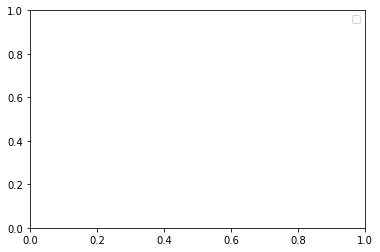

In [0]:
colors = ['red', 'orange', 'blue', 'pink', 'green', 'violet', 'coral']

for i in range(len(losses) // num_epochs - 1):
  plt.plot(list(range(num_epochs)), losses[i * num_epochs: (i + 1) * num_epochs], 
              color=colors[i], label='lr=' + str(learning_rates[i]))
#plt.xlim((1, 100))
plt.legend()
plt.show()

No handles with labels found to put in legend.


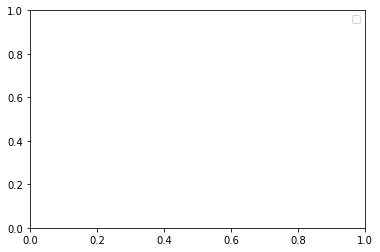

In [0]:
for i in range(len(losses) // num_epochs):
  plt.plot(list(range(num_epochs)), losses[i * num_epochs: (i + 1) * num_epochs], 
              color=colors[i], label='lr=' + str(learning_rates[i]))
#plt.xlim((1, 100))
plt.legend()
plt.show()

In [0]:
#clr
import time
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 20
start_lr = 1e-5
end_lr = 0.1
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        if it == 0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(trainset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

Epoch 1 of 20 took 20.050s
  training loss (in-iteration): 	2.072595
  validation accuracy: 			35.35 %
Epoch 2 of 20 took 20.378s
  training loss (in-iteration): 	1.607396
  validation accuracy: 			42.83 %
Epoch 3 of 20 took 20.613s
  training loss (in-iteration): 	1.360333
  validation accuracy: 			47.43 %
Epoch 4 of 20 took 20.976s
  training loss (in-iteration): 	1.162281
  validation accuracy: 			49.59 %
Epoch 5 of 20 took 20.834s
  training loss (in-iteration): 	1.022081
  validation accuracy: 			49.87 %
Epoch 6 of 20 took 20.662s
  training loss (in-iteration): 	0.961321
  validation accuracy: 			49.44 %
Epoch 7 of 20 took 20.841s
  training loss (in-iteration): 	0.977245
  validation accuracy: 			50.04 %
Epoch 8 of 20 took 20.787s
  training loss (in-iteration): 	0.968029
  validation accuracy: 			51.07 %
Epoch 9 of 20 took 20.771s
  training loss (in-iteration): 	0.965045
  validation accuracy: 			53.07 %
Epoch 10 of 20 took 20.735s
  training loss (in-iteration): 	0.956457
  v

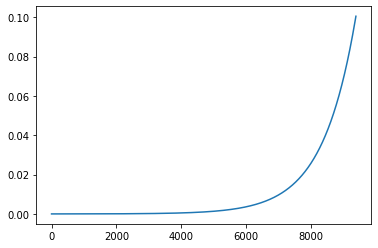

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

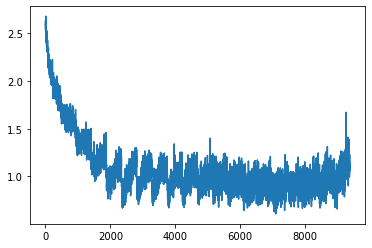

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
import time
#clr
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 31
start_lr = 1e-3
end_lr = 0.7
opt = torch.optim.Adam(resnet18.parameters(), lr=start_lr)

lr_lambda = lambda x: math.exp(x * math.log(start_lr / end_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        if it == 0:
          lr_find_loss.append(loss)
        else:
          loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
          lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    if epoch % 10 == 0:
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss (in-iteration): \t{:.6f}".format(
          np.mean(train_loss[-len(trainset) // batch_size :])))
      print("  validation accuracy: \t\t\t{:.2f} %".format(
          np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
      losses.append(np.array(train_loss).mean())

Epoch 1 of 31 took 20.750s
  training loss (in-iteration): 	1.497434
  validation accuracy: 			46.68 %
Epoch 11 of 31 took 20.489s
  training loss (in-iteration): 	0.028826
  validation accuracy: 			72.05 %
Epoch 21 of 31 took 20.292s
  training loss (in-iteration): 	0.002614
  validation accuracy: 			72.97 %
Epoch 31 of 31 took 20.156s
  training loss (in-iteration): 	0.000768
  validation accuracy: 			73.16 %


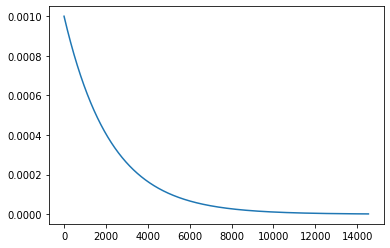

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

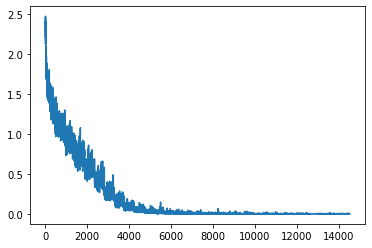

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [0]:
import time
resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 41
start_lr = 1e-4
end_lr = 0.1
factor = 100
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    if epoch % 10 == 0:

      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss (in-iteration): \t{:.6f}".format(
          np.mean(train_loss[-len(trainset) // batch_size :])))
      print("  validation accuracy: \t\t\t{:.2f} %".format(
          np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
      losses.append(np.array(train_loss).mean())

Epoch 1 of 41 took 20.792s
  training loss (in-iteration): 	1.632589
  validation accuracy: 			40.57 %
Epoch 11 of 41 took 20.500s
  training loss (in-iteration): 	0.560200
  validation accuracy: 			66.45 %
Epoch 21 of 41 took 20.358s
  training loss (in-iteration): 	0.263873
  validation accuracy: 			71.75 %
Epoch 31 of 41 took 20.476s
  training loss (in-iteration): 	0.024488
  validation accuracy: 			75.27 %
Epoch 41 of 41 took 20.392s
  training loss (in-iteration): 	0.002315
  validation accuracy: 			75.30 %


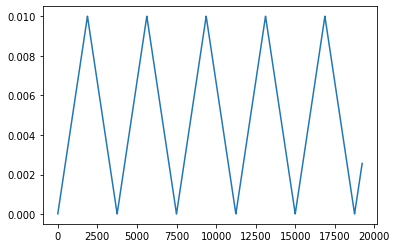

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

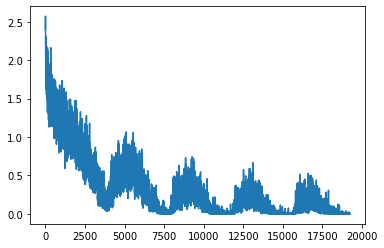

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 51
start_lr = 1e-4
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    if epoch % 10 == 0:
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      print("  training loss (in-iteration): \t{:.6f}".format(
          np.mean(train_loss[-len(trainset) // batch_size :])))
      print("  validation accuracy: \t\t\t{:.2f} %".format(
          np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
      losses.append(np.array(train_loss).mean())

Epoch 1 of 51 took 25.935s
  training loss (in-iteration): 	1.625673
  validation accuracy: 			47.35 %
Epoch 11 of 51 took 25.646s
  training loss (in-iteration): 	0.521315
  validation accuracy: 			68.93 %
Epoch 21 of 51 took 25.630s
  training loss (in-iteration): 	0.232645
  validation accuracy: 			71.67 %
Epoch 31 of 51 took 25.598s
  training loss (in-iteration): 	0.020390
  validation accuracy: 			75.82 %
Epoch 41 of 51 took 25.695s
  training loss (in-iteration): 	0.001650
  validation accuracy: 			75.44 %
Epoch 51 of 51 took 25.765s
  training loss (in-iteration): 	0.053412
  validation accuracy: 			72.41 %


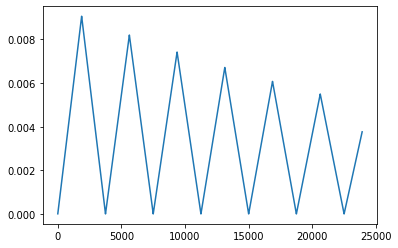

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

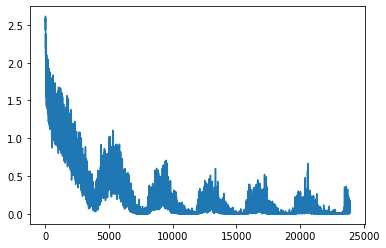

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.3 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 51
start_lr = 1e-3
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())

Epoch 1 of 51 took 39.654s
  training loss (in-iteration): 	1.742999
  validation accuracy: 			40.21 %
Epoch 11 of 51 took 39.102s
  training loss (in-iteration): 	0.978056
  validation accuracy: 			61.92 %
Epoch 21 of 51 took 39.140s
  training loss (in-iteration): 	0.536103
  validation accuracy: 			70.65 %
Epoch 31 of 51 took 39.094s
  training loss (in-iteration): 	0.059520
  validation accuracy: 			74.43 %
Epoch 41 of 51 took 39.107s
  training loss (in-iteration): 	0.005052
  validation accuracy: 			74.90 %
Epoch 51 of 51 took 39.070s
  training loss (in-iteration): 	0.119532
  validation accuracy: 			68.76 %


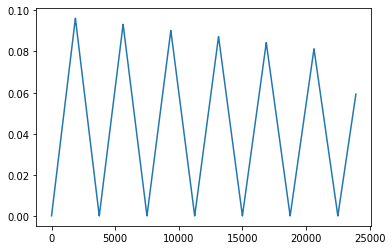

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

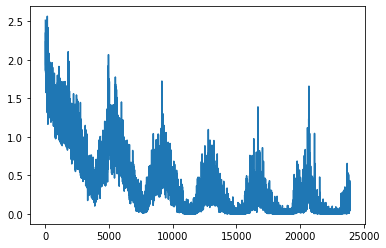

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.7 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 51
start_lr = 1e-3
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5

for epoch in range(num_epochs):
    start_time = time.time()
    k = 0
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        #if k % 20 == 0:
        #  print(k, end=' ')
        k += 1

        scheduler.step()
        opt.zero_grad()
        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)

        lr_find_loss.append(loss)
        #if it == 0:
        #  lr_find_loss.append(loss)
        #else:
        #  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
        #  lr_find_loss.append(loss)
        it += 1

    resnet18.train(False)
    #print('#')
    for (X_batch, y_batch) in valloader:
        #print('@', end='')
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())

Epoch 1 of 51 took 26.180s
  training loss (in-iteration): 	1.755143
  validation accuracy: 			31.31 %
Epoch 11 of 51 took 26.068s
  training loss (in-iteration): 	0.891474
  validation accuracy: 			59.07 %
Epoch 21 of 51 took 26.024s
  training loss (in-iteration): 	0.727585
  validation accuracy: 			67.05 %
Epoch 31 of 51 took 26.121s
  training loss (in-iteration): 	0.054775
  validation accuracy: 			75.12 %
Epoch 41 of 51 took 25.917s
  training loss (in-iteration): 	0.005150
  validation accuracy: 			75.57 %
Epoch 51 of 51 took 26.223s
  training loss (in-iteration): 	0.096201
  validation accuracy: 			72.56 %


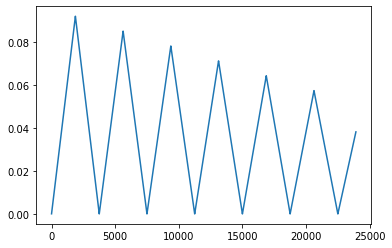

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

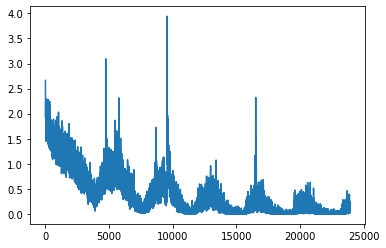

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()

In [0]:
import time
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. * (10 - 0.7 * x)#* math.exp(-x)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    return lr_lambda


resnet18 = models.resnet18(num_classes=10, pretrained=False)
resnet18 = resnet18.cuda()

num_epochs = 51
small_start_lr = 1e-4
small_end_lr = 0.01
start_lr = 0.001
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)

#lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len(trainset)/batch_size))
#scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
lr_lambda = lambda x: math.exp(x * math.log(start_lr / end_lr) / (num_epochs * len(trainset)/batch_size))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

step_size = 4*len(trainset) / batch_size
clr = cyclical_lr(step_size, min_lr=small_start_lr, max_lr=small_end_lr)
small_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

train_loss = []
val_accuracy = []
losses = []

lr_find_loss = []
lr_find_lr = []

it = 0

smoothing = 0.5
small_flag = False

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
      

        if small_flag == False:
            scheduler.step()
        else:
            small_scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
        lr_find_loss.append(loss)
        
        it += 1
        if loss < 0.001:
          small_flag = True

    resnet18.train(False)
    for (X_batch, y_batch) in valloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))

    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(valset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())

Epoch 1 of 51 took 41.166s
  training loss (in-iteration): 	2.286968
  validation accuracy: 			22.15 %
Epoch 11 of 51 took 40.705s
  training loss (in-iteration): 	1.138740
  validation accuracy: 			51.15 %
Epoch 21 of 51 took 41.140s
  training loss (in-iteration): 	0.375702
  validation accuracy: 			54.16 %
Epoch 31 of 51 took 40.504s
  training loss (in-iteration): 	0.056851
  validation accuracy: 			65.32 %
Epoch 41 of 51 took 40.701s
  training loss (in-iteration): 	0.076444
  validation accuracy: 			64.77 %
Epoch 51 of 51 took 40.549s
  training loss (in-iteration): 	0.029368
  validation accuracy: 			65.66 %


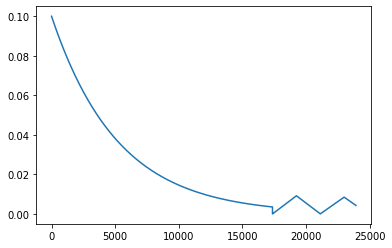

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_lr)
plt.show()

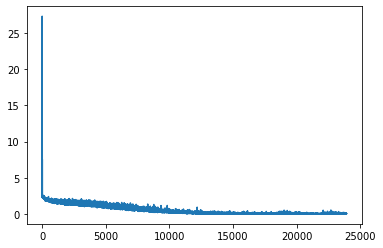

In [0]:
plt.plot(list(range(len(lr_find_lr))), lr_find_loss)
plt.show()